## Regression

In [1]:
#The data contains 300 rows and 3 columns (from the left, A, B, and C). 
#Please build a good regression model which explains column C by a function of A and B. 

#Note: Please do not use any ML libraries or packages. 
#You can simply attach plot of data points and your regression model that fits the data points and of course, 
#code point (preferably Github).

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd

In [3]:
import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/conniezhu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import style

### 1.Data Preparation

#### Outliers:

In [5]:
data = pd.read_csv('Regression.csv',header=None)
Data = np.array(data)
Data.shape

(300, 3)

#### Draw boxplots: column C has an obvious outlier and should be deleted.

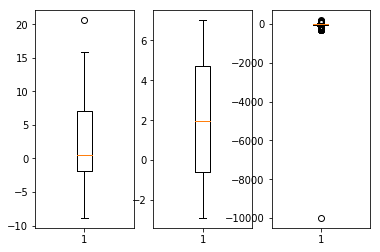

In [6]:
for i in range(1,4):
    plt.subplot(1, 3, i)
    boxplot(Data[:,i-1])   

In [7]:
def inliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 10)
    upper_bound = quartile_3 + (iqr * 10)
    return (ys < upper_bound) & (ys > lower_bound)

In [8]:
# x0:

outlier0 = inliers_iqr(Data[:,0])
itemindex0 = numpy.argwhere(outlier0 == False)
print(itemindex0)

[]


In [9]:
# x1:

outlier1 = inliers_iqr(Data[:,1])
itemindex1 = numpy.argwhere(outlier1 == False)
print(itemindex1)

[]


In [10]:
# y1:

outlier_y = inliers_iqr(Data[:,2])
itemindex_y = numpy.argwhere(outlier_y == False)
print(itemindex_y)

[[200]]


In [11]:
c_Data = np.delete(Data, 200, axis = 0)

In [12]:
c_Data.shape

(299, 3)

#### Find out that value 0 is a critical point for both A and B.

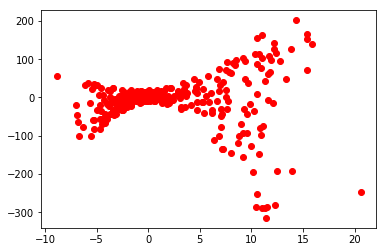

In [13]:
fig,ax=plt.subplots()
ax.scatter(c_Data[:,0],c_Data[:,2],color='r')

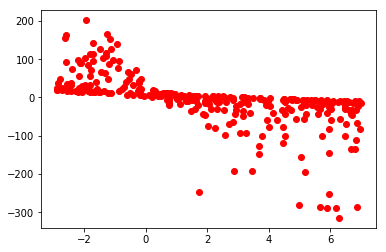

In [14]:
fig,ax=plt.subplots()
ax.scatter(c_Data[:,1],c_Data[:,2],color='r')

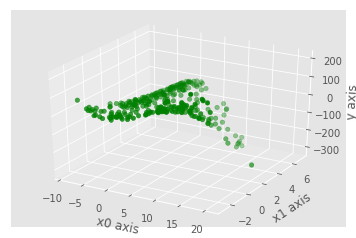

In [15]:
style.use('ggplot')
 
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
 
x0 = list(c_Data[:,0])
x1 = list(c_Data[:,1])
y = list(c_Data[:,2])

 
ax1.scatter(x0, x1, y, c='g', marker='o')
 
ax1.set_xlabel('x0 axis')
ax1.set_ylabel('x1 axis')
ax1.set_zlabel('y axis')
 
plt.show()

#### Introduce Interaction factors to the model

In [16]:
# IX0*X1:
ci_Data = c_Data.copy()
ci_Data[:,0] = np.where(c_Data[:,0] > 0, ci_Data[:,0], 1)
ci_Data[:,0] = np.where(c_Data[:,0] <= 0, ci_Data[:,0], 0)
IX0_X1 = (ci_Data[:,0]*ci_Data[:,1]).reshape(299,1)

# IX1*X0:
ci1_Data = c_Data.copy()
ci1_Data[:,1] = np.where(c_Data[:,1] > 0, ci1_Data[:,1], 1)
ci1_Data[:,1] = np.where(c_Data[:,1] <= 0, ci1_Data[:,1], 0)
IX1_X0 = (ci1_Data[:,1]*ci1_Data[:,0]).reshape(299,1)

In [17]:
# X0*X1:
ci2_Data = c_Data.copy()
X0_X1 = (ci2_Data[:,0]*ci2_Data[:,1]).reshape(299,1)

In [18]:
x_c_Data = np.column_stack((c_Data[:,:2],IX0_X1,IX1_X0,X0_X1))

In [19]:
y_c_Data = c_Data[:,2].reshape(299,1)

#### Normalize Data to range(0,1)

In [20]:
def MaxMinNormalization(x,Max,Min):
    x = (x - Min) / (Max - Min)
    return x

In [21]:
x_c_Data[:,0] = MaxMinNormalization(x_c_Data[:,0], max(x_c_Data[:,0]), min(x_c_Data[:,0]))
x_c_Data[:,1] = MaxMinNormalization(x_c_Data[:,1], max(x_c_Data[:,1]), min(x_c_Data[:,1]))
x_c_Data[:,2] = MaxMinNormalization(x_c_Data[:,2], max(x_c_Data[:,2]), min(x_c_Data[:,2]))
x_c_Data[:,3] = MaxMinNormalization(x_c_Data[:,3], max(x_c_Data[:,3]), min(x_c_Data[:,3]))
x_c_Data[:,4] = MaxMinNormalization(x_c_Data[:,4], max(x_c_Data[:,4]), min(x_c_Data[:,4]))

y_c_Data[:,0] = MaxMinNormalization(y_c_Data[:,0], max(y_c_Data[:,0]), min(y_c_Data[:,0]))

### 2. Lsq, Loss & Likelihood

In [22]:
def lsqClosedForm(X, y):
    """
    Use closed form solution for least squares minimization

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    y : 1D array
        Observed function values

    Returns
    -------
    w : 1D array
        d+1 length vector
    """
    return np.dot(np.linalg.pinv(X), y)

In [23]:
def symmLoss(X, w ,y):
    """
    Get the symmetric squared loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    loss : a scalar
        The loss calculated by the symmetric loss formula
    """
    return np.mean((np.dot(X, w) - y)**2)

In [24]:
def logLikelihood(X, w, y):
    """
    Get the estimated variance, and the log likelihood of the data

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    simga2 : a scalar
        The estimated variance (sigma squared)
    loglike : a scalar
        The log-likelihood under the Gaussian noise model N(0,sigma2)
    """
    N = X.shape[0]   # number of rows in X
    # now estimate the variance of the Gaussian noise (sigma2 stands for :sigma^2)
    sigma2 = 0
    for i in range(len(y)):
        sigma2 += (y[i] - np.dot(X[i], w))**2
    sigma2 = sigma2/len(y)
    # normalized log-likelihood (mean of per-data point log-likelihood of the model given by w,sigma2)
    loglike = - 1 / 2.0 * np.log(2*np.pi*sigma2) - np.mean((np.dot(X, w) - y)**2) / (sigma2 * 2)
    return np.sqrt(sigma2), loglike

#### Calculate Matrix C for Multiple (degree) Linear Regression

In [25]:
def degexpand(X, deg, C=None):
    """
    Prepares data matrix with a column of ones and polynomials of specified
    degree.

    Parameters
    ----------
    X : 2D array
        n x d data matrix (row per example)
    deg : integer
        Degree of polynomial
    C : 1D array
        Scaling weights. If not specifed, weights are calculated to fit each
        columns of X in [-1, 1].
        Note: It is shown in problem set 1 that this normalization does
        not affect linear regression, as long as it is applied
        consistently to training *and* test data.

    Returns
    -------
    out_X : 2D array
        n x (2 * d + 1) data matrix (row per example)
        The output is arranged as follows:
            - X[:, 0] is all ones
            - X[:, 1] is x_1
            - X[:, 2] is x_1^2
            - ...
            - X[:, deg] is x_1^deg
            - X[:, deg+1] is x_2
            - X[:, deg+2] is x_2^2
            - etc.
    C : 1D array
        Scaling weights that were used. Useful if no C was specified.
    """
    assert X.ndim == 2
    #m, n = X.shape
    n, m = X.shape

    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C
    return out_X, C

In [26]:
min_loss = np.Inf
W = [] 

# Try degree 1 to 5
for deg in [1,2,3,4,5]:
    X, C = degexpand(x_c_Data, deg)
    #print(X.shape)
    #print(C.shape)
    
    # Get the result by applying normal equation
    w = lsqClosedForm(X, y_c_Data)
    #print(w)
    W.append(w)
    # compute loss on training
    loss = symmLoss(X, w, y_c_Data)
    #print(X.shape)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('sigma: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y_c_Data))

degree 1:
train loss 0.004209
sigma: 0.064878 
log-likelihood 1.316312

degree 2:
train loss 0.000575
sigma: 0.023970 
log-likelihood 2.312020

degree 3:
train loss 0.000551
sigma: 0.023479 
log-likelihood 2.332725

degree 4:
train loss 0.000515
sigma: 0.022698 
log-likelihood 2.366551

degree 5:
train loss 0.000497
sigma: 0.022283 
log-likelihood 2.384971



#### Conclusion
From above cell, we can say that mutiple linear regression with degree 2 is a good fit. Because the loss of model2 is much lower than model1(degree1) and uses much fewer parameters than model3-5. 

### Best Model:

In [27]:
# W Matrix:
sol2 = W[1]
print(sol2)

[[ 0.78288763]
 [ 1.06881411]
 [-1.16205085]
 [-0.33498635]
 [ 0.2473052 ]
 [ 0.30075318]
 [-0.30950159]
 [-1.48693101]
 [ 1.52126462]
 [ 0.24374905]
 [-0.84424189]]


### 3. Visualization of regression results

Green points are the given data, while red points are the predicted data.

#### degree 1 plot:

In [28]:
sol = W[0]
X, C = degexpand(x_c_Data, 1)
yhat = np.dot(X, sol)

In [29]:
c_Data[:,0] = MaxMinNormalization(c_Data[:,0], max(c_Data[:,0]), min(c_Data[:,0]))
c_Data[:,1] = MaxMinNormalization(c_Data[:,1], max(c_Data[:,1]), min(c_Data[:,1]))
c_Data[:,2] = MaxMinNormalization(c_Data[:,2], max(c_Data[:,2]), min(c_Data[:,2]))

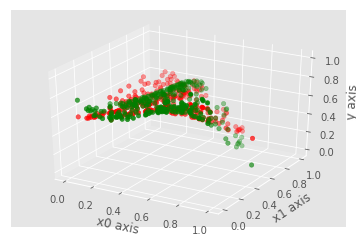

In [30]:
style.use('ggplot')
 
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
 
x0 = list(c_Data[:,0])
x1 = list(c_Data[:,1])
y = list(c_Data[:,2])
yhat1 = list(yhat[:,0])
 
ax1.scatter(x0, x1, y, c='g', marker='o')
ax1.scatter(x0, x1, yhat1, c='r', marker='o')
 
ax1.set_xlabel('x0 axis')
ax1.set_ylabel('x1 axis')
ax1.set_zlabel('y axis')
 
plt.show()

#### degree 2 plot

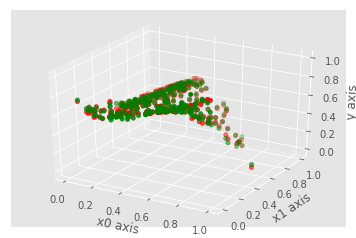

In [31]:
sol2 = W[1]
X, C = degexpand(x_c_Data, 2)
yhat = np.dot(X, sol2)

style.use('ggplot')
 
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
 
x0 = list(c_Data[:,0])
x1 = list(c_Data[:,1])
y = list(c_Data[:,2])
yhat2 = list(yhat[:,0])
 
ax1.scatter(x0, x1, y, c='g', marker='o')
ax1.scatter(x0, x1, yhat2, c='r', marker='o')
 
ax1.set_xlabel('x0 axis')
ax1.set_ylabel('x1 axis')
ax1.set_zlabel('y axis')
 
plt.show()

#### degree 5 plot

In [32]:
sol5 = W[4]
X, C = degexpand(x_c_Data, 5)
yhat = np.dot(X, sol5)

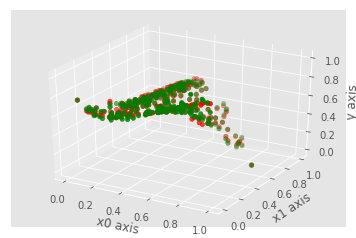

In [33]:
style.use('ggplot')
 
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
 
x0 = list(c_Data[:,0])
x1 = list(c_Data[:,1])
y = list(c_Data[:,2])
yhat5 = list(yhat[:,0])
 
ax1.scatter(x0, x1, y, c='g', marker='o')
ax1.scatter(x0, x1, yhat5, c='r', marker='o')
 
ax1.set_xlabel('x0 axis')
ax1.set_ylabel('x1 axis')
ax1.set_zlabel('y axis')
 
plt.show()